# Train MNIST dataset with PyTorch Data Loading and flax

## 1. Loading data

In [57]:
import numpy as np
import torch
from torch.utils import data
from torchvision.datasets import MNIST

from jax import numpy as jnp

In [58]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.expand_dims(np.array(pic, dtype=jnp.float32), axis=-1) / 255.0
    # return np.array(pic, dtype=jnp.float32) 

In [59]:
batch_size = 128

# Define dataset
mnist_dataset = MNIST(root='./data', download=True, transform=FlattenAndCast())
mnist_dataset_test = MNIST(root='./data', download=True, train=False, transform=FlattenAndCast())

# train_images = jnp.array(mnist_dataset.data) / 255.0
# train_labels = jnp.array(mnist_dataset.targets)

# test_images = jnp.array(mnist_dataset_test.data) / 255.0
# test_labels = jnp.array(mnist_dataset_test.targets)

train_loader = NumpyLoader(dataset=mnist_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=0)
test_loader = NumpyLoader(dataset=mnist_dataset_test,
                          batch_size=batch_size,
                          num_workers=0)

7


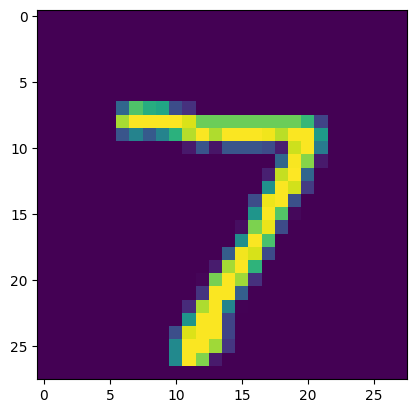

In [60]:
from matplotlib import pyplot as plt

test=next(iter(test_loader))
img = test[0][0]
print(test[1][0])
plt.imshow(img)
plt.show()

## 2. Define a network

In [61]:
from flax import linen as nn # Linen API

class CNN(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1)) # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

## 3. View Model Layers

In [62]:
import jax
import jax.numpy as jnp

cnn = CNN()
print(cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1)))) # (batch, h, w, channel)


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,… │ float32[1,10]     │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,… │ float32[1,28,28,… │ bias: float32[32] │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[3,3,1,32] │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 320 (1.3 KB)      │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_1  │ Conv   │ float3

## 4. Create a `TrainState`

A common pattern in Flax is to create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state.

In [63]:
from clu import metrics
from flax.training import train_state # Useful dataclass to keep train state
from flax import struct               # Flas dataclass
import optax                          # Common loss functions and optimizers

In [64]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [65]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
    params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initializing parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
            apply_fn=module.apply,
            params=params,
            tx=tx,
            metrics=Metrics.empty())

## 5. Training step

A function that:
- Evaluates the neural network given the parameters and a batch of input images with `TrainState.apply_fn`;
- Computes the cross entropy loss, using the predefined `optax.softmax_cross_entropy_with_integer_labels()`. Note that this function expects integer labels, so there is no need to convert labels to onehot encoding.
- Evaluates the gradient of the loss function using `jax.grad`.
- Applies a pytree of gradients to the optimizer to update the model's parameters.

In [46]:
@jax.jit
def train_step(state, images, targets):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

## 6. Metric computation

In [47]:
@jax.jit
def compute_metrics(*, state, images, targets):
    logits = state.apply_fn({'params': state.params}, images)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=targets, loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

## 7. Set Seed and train params

In [48]:
num_epochs = 10
learning_rate = 0.01
momentum = 0.9

torch.manual_seed(0)
init_rng = jax.random.PRNGKey(0)

## 8. Initialize the `TrainState`

In [49]:
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng

## 9. Train and evaluate

In [50]:
num_steps_per_epoch = len(train_loader)

In [51]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [ ]:
for curr_epoch in range(num_epochs):
    for i, (images, targets) in enumerate(train_loader):
        # Run optimization steps over training batches and compute batch metrics
        state = train_step(state, images, targets)
        state = compute_metrics(state=state, images=images, targets=targets)
    
    for metric, value in state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value)
        
    state = state.replace(metrics=state.metrics.empty())

    # test_state = state
    # for images, targets in enumerate(test_loader):
    #     test_state = compute_metrics(state=test_state, images=images, targets=targets)

    # for metric, value in test_state.metrics.compute().items():
    #     metrics_history[f'test_{metric}'].append(value)

    print(f'Epoch: {curr_epoch + 1}:')
    print(f'\tTrain Metrics: Loss={metrics_history["train_loss"][-1]:.4f}, Accuracy={metrics_history["train_accuracy"][-1]*100:.4f}')
    # print(f'\tTest Metrics: Loss={metrics_history["test_loss"][-1]:.4f}, Accuracy={metrics_history["test_accuracy"][-1]:.4f}')